### Jump to: <a id="contents"></a>

**Getting started**
- [import packages](#imp_pac)
- [intro to data](#intro)

*First time*
- [field and category data](#field_cat)
- [article data](#article)
- [find hyperlinks](#hyperlinks)

*Later*
- [import prepared data](#import_prep)

**Networks**
- [build hyperlink network](#build_graph)
- [build category network](#cat_network)
- [add features](#add_features)
- [degree distribution](#degree_dist)

**Analysing field-specific network phenomena**
- [describing fields](#field_spec)
- [predicting field with network attributes](#pred)

**Category network visualization**
- [pyvis visualization](#pyvis)
- [circular visualization](#circular)

-------------------------

### import packages <a id="imp_pac">

[**back**](#contents)

In [1]:
import pandas as pd
import numpy as np
import math

import networkx as nx
from pyvis import network as net
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import pickle

from tqdm import tqdm_notebook as tqdm

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit

from operator import or_
from functools import reduce
from itertools import combinations, repeat, chain, permutations

import glob

In [2]:
sns.set()
matplotlib.rcParams["figure.figsize"] = [12, 10]

------------

### intro to data <a id="intro">

[**back**](#contents)

**DATA SOURCE**:

[**Wikipedia hyperlinks**](https://snap.stanford.edu/data/wiki-topcats.html)

**ACADEMIC FIELDS**:

based on [**Wikipedia's own classification**](https://en.wikipedia.org/wiki/List_of_academic_fields)

**Formal sciences**
- computer science
- logic
- mathematics
- (omitted due to lack of data: systems science)

**Natural sciences**
- biology
- chemistry
- earth science
- physics
- space sciences

**Humanities and social science**
- anthropology
- linguistics
- philosophy
- economics
- political science
- sociology
- psychology
- (omitted due to the narrow scope of this analysis: history, religion, arts, geography, interdisciplinary studies)

------------

### field and category data <a id="field_cat"></a>

[**back**](#contents)

In [3]:
all_categories = {}

with open("input_data/wiki-topcats-categories.txt", "r") as fp:
    l = fp.readline().strip("\n").split(" ")
    while len(l) > 1:
        all_categories[l[0].split(":")[1].strip(";")] = set(l[1:])
        l = fp.readline().strip("\n").split(" ")

In [4]:
def contains(string, list_):

    for l in list_:
        if l.lower() in string.lower():
            return True

    return False

In [5]:
def catsearch(keyword_dict):

    return [
        {"category": k, "nodes": v}
        for k, v in all_categories.items()
        if contains(k, keyword_dict["keywords"])
        and not contains(k, keyword_dict["omit"])
    ]

In [6]:
with open("input_data/keywords.p", "rb") as fp:
    keywords = pickle.load(fp)

In [7]:
fields = pd.read_csv("input_data/fields.csv").drop("Unnamed: 0", axis=1)

In [8]:
categories = pd.concat(
    fields["field"]
    .apply(lambda field: pd.DataFrame(catsearch(keywords[field])).assign(field=field))
    .tolist()
)

In [9]:
categories.sample(5)

,category,nodes,field
11,Philosophy_of_science,"{64468, 64712, 65842, 64882, 65296, 65794, 648...",philosophy
7,Chemical_processes,"{478990, 108068, 7330, 820012, 32954, 108349, ...",chemistry
54,Computer_memory,"{1725569, 1729784, 205909, 1729200, 1621748, 1...",computer science
25,Computer_arithmetic,"{41975, 330371, 330373, 645732, 642584, 642816...",computer science
19,History_of_mathematics,"{369345, 1104947, 1101004, 1102027, 1444943, 4...",mathematics


In [10]:
categories.shape

(304, 3)

------------

### article data <a id="article">

[**back**](#contents)

In [11]:
def find_names(nodes):

    names = {}

    with open("input_data/wiki-topcats-page-names.txt", "r") as fp:
        _bar = tqdm()
        l = fp.readline().strip("\n").split(" ")
        while len(l) > 1:
            if l[0] in nodes:
                names[l[0]] = " ".join(l[1:])
            l = fp.readline().strip("\n").split(" ")
            _bar.update()

    return (
        pd.DataFrame.from_dict(names, orient="index")
        .reset_index()
        .rename(columns={"index": "node", 0: "title"})
    )

In [12]:
articles = pd.concat(
    categories.apply(
        lambda r: pd.DataFrame(
            [
                {"field": r["field"], "category": r["category"], "node": n}
                for n in r["nodes"]
            ]
        ),
        axis=1,
    ).tolist()
).pipe(lambda df: df.merge(find_names(set(df["node"].values)), on="node"))

In [14]:
articles.sample(5)

,field,category,node,title
47832,economics,Political_and_economic_think_tanks_in_the_Unit...,1410874,Institute for Advanced Strategic and Political...
36880,anthropology,American_anthropologists,1128155,Karl Taube
33584,space sciences,Astronomical_X-ray_sources,869343,NGC 4151
48862,economics,Economics_books,109054,Liberalism (book)
34692,space sciences,American_astronomers,872264,James V. Scotti


In [15]:
articles.to_csv("output_data/all_articles.csv")

---------------

------------------

### find hyperlinks <a id="hyperlinks"></a>

[**back**](#contents)

In [16]:
def find_link_edges(nodes):

    edges = []

    with open("input_data/wiki-topcats.txt", "r") as fp:
        _bar = tqdm()
        l = fp.readline().strip("\n").split(" ")
        while len(l) > 1:
            if (l[0] in nodes) and (l[1] in nodes):
                edges.append([l[0], l[1]])
            l = fp.readline().strip("\n").split(" ")
            _bar.update()

    return edges

In [17]:
edges = find_link_edges(set(articles["node"].values))

In [18]:
pd.DataFrame(edges).to_csv("output_data/wiki_all_hyperlink_edges.csv")

--------------

### import prepared data <a id="import_prep">

[**back**](#contents)

In [3]:
files = {idx: f for idx, f in enumerate(sorted(glob.glob("output_data/*.csv")))}

In [4]:
files

{0: 'output_data/all_articles.csv',
 1: 'output_data/all_hyperlink_edges.csv',
 2: 'output_data/category_data.csv',
 3: 'output_data/category_edges.csv',
 4: 'output_data/field_dummies.csv',
 5: 'output_data/randomized_field_coeff_matrix.csv',
 6: 'output_data/randomized_field_data.csv',
 7: 'output_data/randomized_field_link_matrix.csv',
 8: 'output_data/randomized_field_links.csv',
 9: 'output_data/randomized_hyperlink_edges.csv',
 10: 'output_data/randomized_node_data.csv',
 11: 'output_data/randomized_reg_df.csv',
 12: 'output_data/wiki_field_coeff_matrix.csv',
 13: 'output_data/wiki_field_data.csv',
 14: 'output_data/wiki_field_link_matrix.csv',
 15: 'output_data/wiki_field_links.csv',
 16: 'output_data/wiki_hyperlink_edges.csv',
 17: 'output_data/wiki_node_data.csv',
 18: 'output_data/wiki_reg_df.csv'}

In [5]:
def get(nth):

    df = pd.read_csv(files[nth])
    if "Unnamed: 0" in df.columns:
        return df.drop("Unnamed: 0", axis=1)
    return df

In [6]:
field_coeff_matrix = get(12).set_index("field")

In [7]:
fields = get(13)

In [8]:
field_link_matrix = get(14).set_index("edge_from")

In [44]:
filtered = get(17).assign(node=lambda df: df["node"].astype(str))

In [10]:
field_dummies = (
    get(4).assign(node=lambda df: df["node"].astype(str)).set_index("node").sort_index()
)

----------

### build hyperlink network <a id="build_graph"></a>

[**back**](#contents)

In [19]:
def graph(nodes, edges, weighted, directed):

    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    G.add_nodes_from(nodes)

    if weighted:
        G.add_weighted_edges_from(edges)
    else:
        G.add_edges_from(edges)

    print(nx.info(G))

    return G

In [20]:
G_link = graph(articles["node"].unique(), edges, False, True)

Name: 
Type: DiGraph
Number of nodes: 42878
Number of edges: 287940
Average in degree:   6.7153
Average out degree:   6.7153


In [21]:
L_link = G_link.subgraph(max(nx.weakly_connected_components(G_link), key=len))

In [22]:
print(nx.info(L_link))

Name: 
Type: DiGraph
Number of nodes: 39710
Number of edges: 287725
Average in degree:   7.2457
Average out degree:   7.2457


In [23]:
filtered = articles.loc[articles["node"].isin(set(L_link.nodes()))].reset_index(
    drop=True
)

In [29]:
pd.DataFrame(list(L_link.edges())).rename(columns={0: "from", 1: "to"}).to_csv(
    "output_data/wiki_hyperlink_edges.csv"
)

#### inspecting disconnected nodes

In [30]:
lonely_nodes = set(articles.loc[~articles["node"].isin(set(filtered["node"])), "node"])

In [31]:
articles.loc[articles["node"].isin(lonely_nodes), "category"].value_counts().loc[
    lambda s: s > 50
]

Alumni_of_the_London_School_of_Economics         286
Fellows_of_the_Royal_Geographical_Society        111
American_computer_scientists                      88
American_psychologists                            79
Mesozoic_geologic_formations                      75
Mathematics_and_Computing_Colleges_in_England     72
20th-century_mathematicians                       69
American_mathematicians                           66
American_anthropologists                          66
American_biologists                               59
American_astronomers                              57
American_sociologists                             55
American_meteorologists                           55
American_economists                               54
Geography-related_lists                           52
Name: category, dtype: int64

In [32]:
lonely_edges = (
    pd.DataFrame(edges)
    .loc[lambda df: df[0].isin(lonely_nodes) & df[1].isin(lonely_nodes)]
    .values
)

In [33]:
lonely_graph = graph(lonely_nodes, lonely_edges, False, True)

Name: 
Type: DiGraph
Number of nodes: 3168
Number of edges: 215
Average in degree:   0.0679
Average out degree:   0.0679


In [34]:
largest_lonely = lonely_graph.subgraph(max(nx.weakly_connected_components(lonely_graph), key=len))

In [35]:
print(nx.info(largest_lonely))

Name: 
Type: DiGraph
Number of nodes: 35
Number of edges: 34
Average in degree:   0.9714
Average out degree:   0.9714


-------------------

### build category network <a id="cat_network"></a>

[**back**](#contents)

In [36]:
cat_edges = []

In [37]:
for (c1, n1), (c2, n2) in tqdm(
    combinations(
        categories[["category", "nodes"]]
        .set_index("category")
        .to_dict()["nodes"]
        .items(),
        2,
    )
):
    w = len(n1 & n2) / min(len(n1), len(n2))
    if w:
        cat_edges.append([c1, c2, w])

In [38]:
G_cat = graph(categories["category"].values, cat_edges, True, False)

Name: 
Type: Graph
Number of nodes: 293
Number of edges: 3241
Average degree:  22.1229


In [39]:
nx.is_connected(G_cat)

False

In [40]:
pd.DataFrame(cat_edges).rename(columns={0: "edge_1", 1: "edge_2", 2: "weight"}).to_csv(
    "output_data/category_edges.csv"
)

----------

### add features <a id="add_features"></a>

[**back**](#contents)

##### add degrees, neighbor connectivity, clustering

In [41]:
def neighbor_connectivity(node, graph, weighted, directed):

    w = "weight" if weighted else None

    if directed:
        arr = np.array(
            [
                graph.in_degree(n, weight=w) + graph.out_degree(n, weight=w)
                for n in list(graph.successors(node)) + list(graph.predecessors(node))
            ]
        )

    else:

        arr = np.array([graph.degree(n, weight=w) for n in list(graph.neighbors(node))])

    if arr.shape[0] == 0:
        return 0
    return arr.mean()

In [42]:
def clustering(node, graph):
    
    return nx.clustering(graph, node)

In [43]:
filtered = filtered.merge(
    filtered[["node"]]
    .drop_duplicates()
    .assign(
        in_degree=lambda df: df["node"].apply(lambda n: L_link.in_degree(n)),
        out_degree=lambda df: df["node"].apply(lambda n: L_link.out_degree(n)),
        neighbor_conn=lambda df: df["node"].apply(
            neighbor_connectivity, args=(L_link, False, True)
        ),
        clustering=lambda df: df["node"].apply(clustering, graph=L_link),
    ),
    on="node",
)

In [44]:
categories = categories.assign(
    degree=categories["category"].apply(lambda c: G_cat.degree(c, weight="weight")),
    neighbor_conn=lambda df: df["category"].apply(
        neighbor_connectivity, args=(G_cat, True, False)
    ),
    clustering=lambda df: df["category"].apply(clustering, graph=G_cat),
)

In [45]:
categories.to_csv("output_data/category_data.csv")

-------------

### degree distribution <a id="degree_dist"></a>

[**back**](#contents)

In [46]:
def degree_dist(degrees_list, title="Degree distribution", labels=["Degree"]):

    colors = ["#0d1667", "#6dc9c8"]

    low = np.log10(max(1, min([degrees.min() for degrees in degrees_list])))
    high = max([np.log10(degrees.max()) for degrees in degrees_list])
    x = np.logspace(low, high)

    for idx, degrees in enumerate(degrees_list):
        plt.scatter(
            x[1:],
            pd.cut(degrees, bins=x).value_counts(normalize=True),
            c=colors[idx],
            label=labels[idx],
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1, (10 ** (int(high) + 1)))
    plt.ylim(10 ** (-5), 1)
    plt.xlabel("k")
    plt.ylabel("p(k)")
    plt.title(title)
    plt.legend()

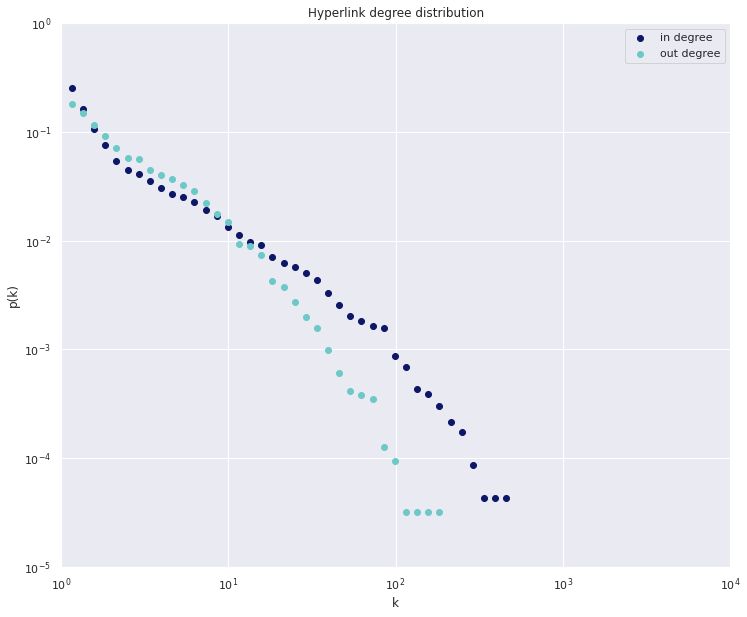

In [47]:
degree_dist(
    [
        filtered.drop_duplicates("node")["in_degree"],
        filtered.drop_duplicates("node")["out_degree"],
    ],
    "Hyperlink degree distribution",
    labels=["in degree", "out degree"],
)

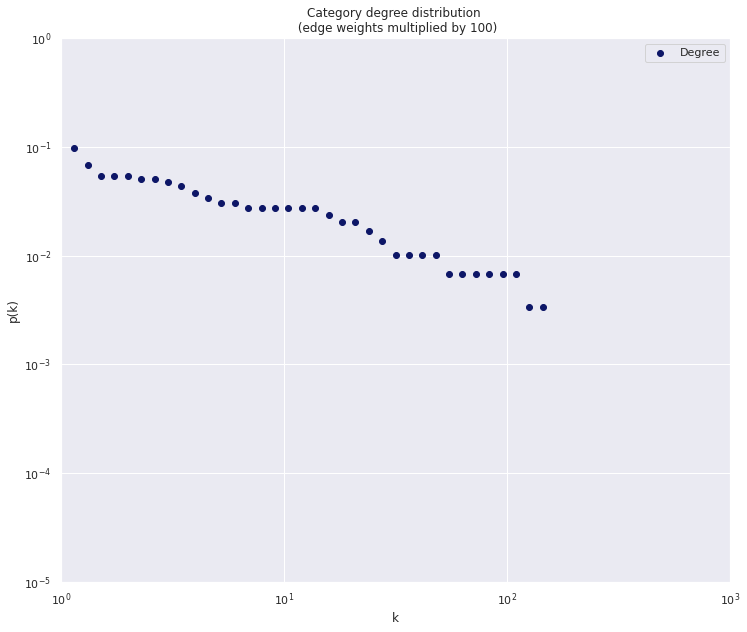

In [48]:
degree_dist(
    [categories["degree"] * 100],
    "Category degree distribution \n (edge weights multiplied by 100)",
)

-------------

### describing fields <a id="field_spec"></a>

[**back**](#contents)

In [50]:
field_links = (
    (
        pd.DataFrame(edges, columns=["from", "to"])
        .merge(
            filtered[["node", "field"]].drop_duplicates(),
            left_on="from",
            right_on="node",
        )
        .drop("node", axis=1)
        .rename(columns={"field": "edge_from"})
        .merge(
            filtered[["node", "field"]].drop_duplicates(), left_on="to", right_on="node"
        )
        .drop("node", axis=1)
        .rename(columns={"field": "edge_to"})
    )
    .groupby(["from", "to"])
    .apply(lambda df: df.assign(weight=1 / df.shape[0]))
    .reset_index(drop=True)
)

In [51]:
field_links.to_csv("output_data/wiki_field_links.csv")

In [52]:
filtered = (
    filtered.merge(
        pd.DataFrame(
            field_links.loc[lambda df: df["edge_from"] == df["edge_to"]]
            .groupby(["from", "edge_from"])["weight"]
            .sum()
        )
        .reset_index()
        .rename(
            columns={
                "from": "node",
                "edge_from": "field",
                "weight": "within_field_out_degree",
            }
        ),
        how="left",
        on=["node", "field"],
    )
    .merge(
        pd.DataFrame(
            field_links.loc[lambda df: df["edge_from"] == df["edge_to"]]
            .groupby(["to", "edge_to"])["weight"]
            .sum()
        )
        .reset_index()
        .rename(
            columns={
                "to": "node",
                "edge_to": "field",
                "weight": "within_field_in_degree",
            }
        ),
        how="left",
        on=["node", "field"],
    )
    .fillna(0)
)

In [53]:
filtered.to_csv("output_data/wiki_node_data.csv")

In [54]:
field_link_matrix = field_links.pivot_table(
    columns="edge_to", index="edge_from", values="weight", aggfunc="sum"
)

In [55]:
field_link_matrix.to_csv("output_data/wiki_field_link_matrix.csv")

In [56]:
article_weights = filtered.groupby("node").apply(
    lambda df: df[["field"]].drop_duplicates().assign(weight=lambda df: 1 / df.shape[0])
)

In [57]:
fields = (
    fields.merge(
        pd.DataFrame(
            filtered.groupby("field").apply(
                lambda df: df.drop_duplicates("node").shape[0]
            )
        ),
        on="field",
    )
    .rename(columns={0: "n_articles"})
    .merge(pd.DataFrame(article_weights.groupby("field")["weight"].sum()), on="field")
    .rename(columns={"weight": "weighted_articles"})
    .assign(rel_size=lambda df: df["weighted_articles"] / df["weighted_articles"].sum())
)

##### add measures based on Rinia et.al.

In [58]:
fields = fields.assign(
    ext_citations=fields["field"].apply(
        lambda f: (field_link_matrix.loc[:, f].sum() - field_link_matrix.loc[f, f])
    )
).assign(
    rel_ext_use=lambda df: df["ext_citations"]
    / field_link_matrix.sum().sum()
    * (1 - fields["rel_size"])
    / fields["rel_size"],
    ext_cit_avg=lambda df: df["ext_citations"] / fields["weighted_articles"],
    imp_exp_ratio=lambda df: df["ext_citations"]
    / fields["field"].apply(
        lambda f: (field_link_matrix.loc[f].sum() - field_link_matrix.loc[f, f])
    ),
)

In [59]:
fields = fields.merge(
    pd.DataFrame(field_links.groupby("edge_from")["weight"].sum())
    .reset_index()
    .rename(columns={"edge_from": "field", "weight": "field_out_degree"}),
    on="field",
).merge(
    pd.DataFrame(field_links.groupby("edge_to")["weight"].sum())
    .reset_index()
    .rename(columns={"edge_to": "field", "weight": "field_in_degree"}),
    on="field",
)

In [60]:
fields.to_csv("output_data/wiki_field_data.csv")

In [61]:
def fields_pie_chart(attr, title):

    sorted_fields = fields.sort_values(attr)

    fig, ax = plt.subplots(figsize=(13, 13))

    plt.pie(
        sorted_fields[attr].values,
        labels=[
            "{} ({}%)".format(r["field"], round(100 * r[attr], 2))
            for idx, r in sorted_fields.iterrows()
        ],
        colors=sns.cubehelix_palette(fields.shape[0]),
    )

    plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.7, color="white"))
    plt.title(title, fontsize="x-large")

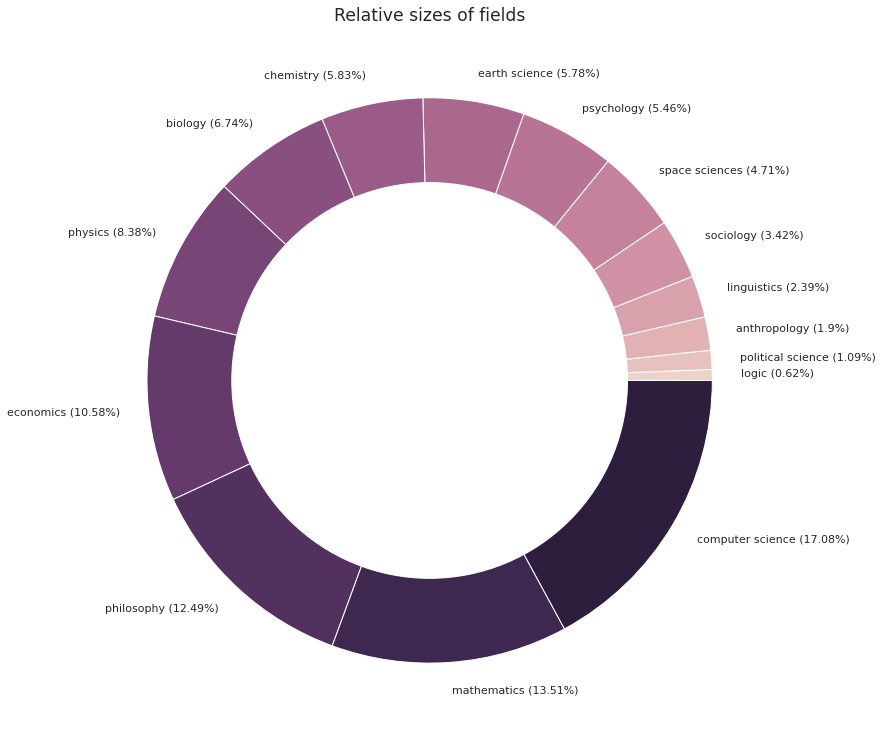

In [62]:
fields_pie_chart("rel_size", "Relative sizes of fields")

In [63]:
def fields_bar_chart(attr, title, ylim=None, annot=True):

    sorted_fields = fields.sort_values(attr, ascending=False)

    plt.bar(
        sorted_fields["field"].values,
        sorted_fields[attr].values,
        color=sns.cubehelix_palette(fields.shape[0]),
    )

    plt.xticks(rotation=30)
    
    if ylim:
        plt.ylim(0, ylim)

    if annot:
        for idx, r in enumerate(sorted_fields[attr]):
            plt.text(x=idx - 0.25, y=1.01 * r, s=round(r, 2), size=12)

    plt.title(title, fontsize="x-large")

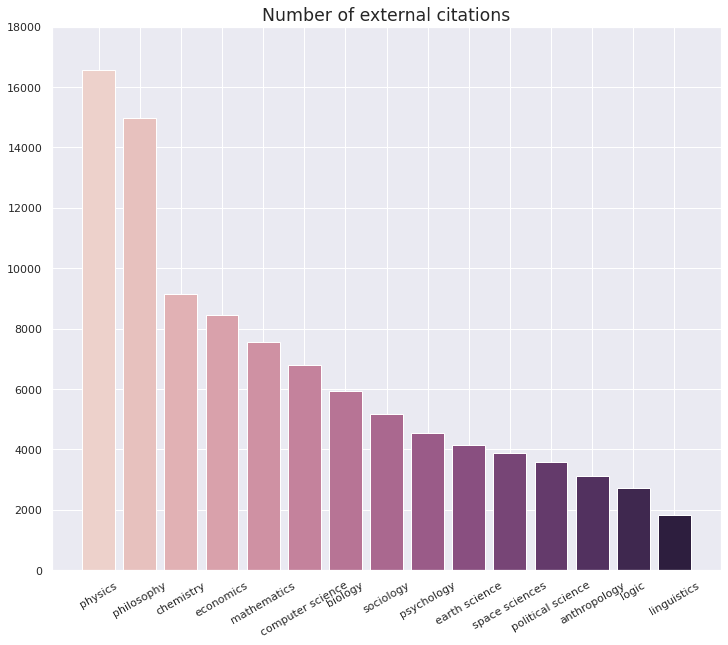

In [64]:
fields_bar_chart("ext_citations", "Number of external citations", 18000, False)

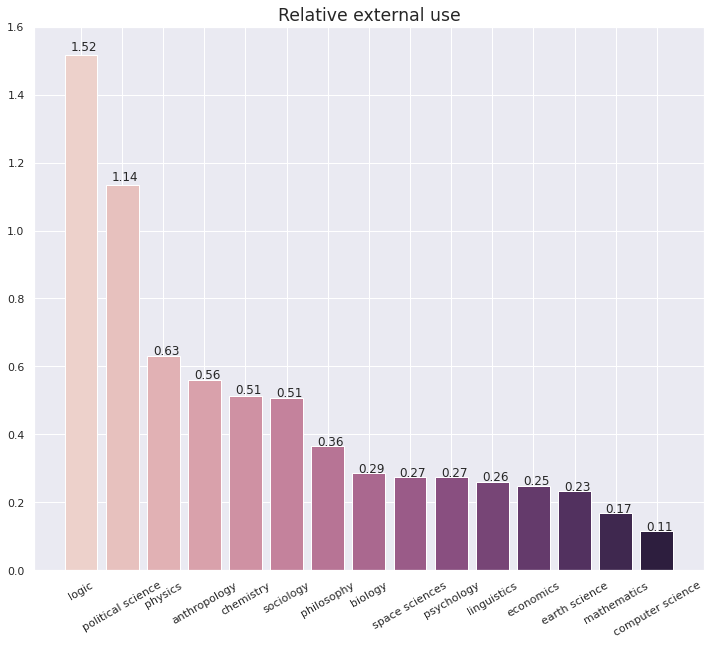

In [65]:
fields_bar_chart("rel_ext_use", "Relative external use", ylim=1.6)

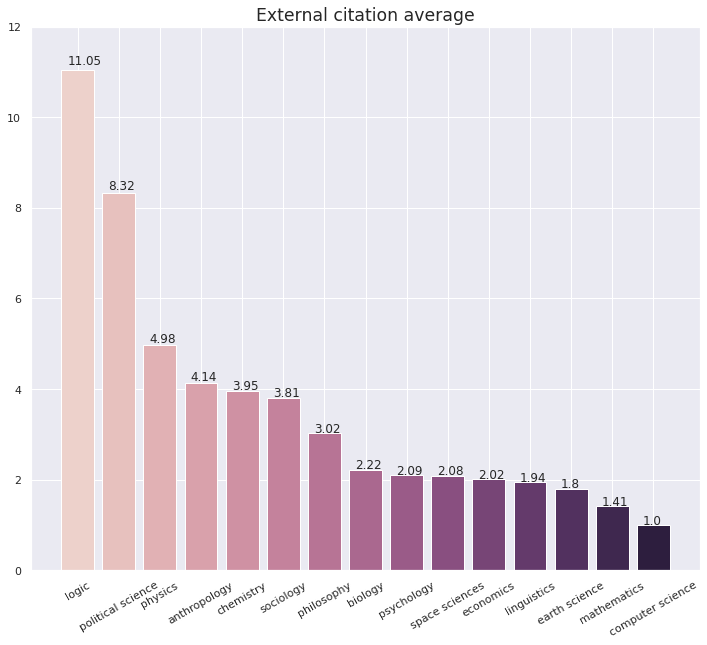

In [66]:
fields_bar_chart("ext_cit_avg", "External citation average", ylim=12)

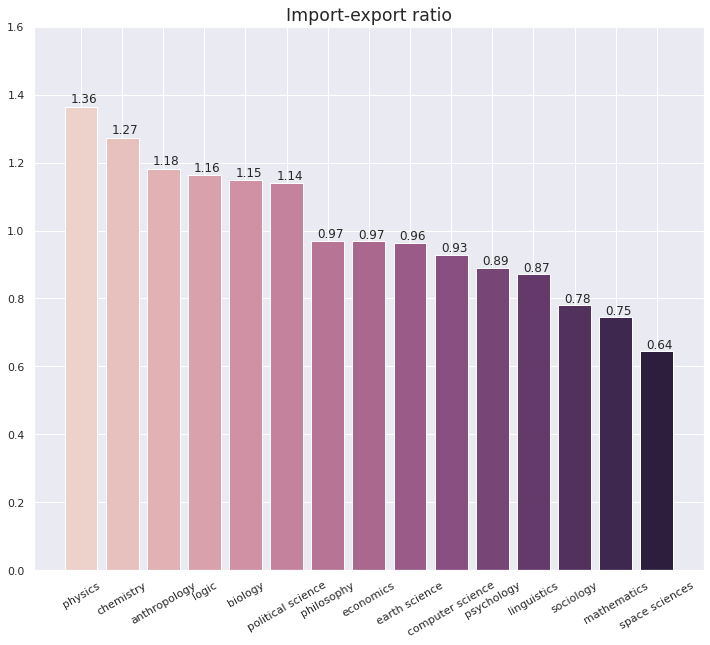

In [67]:
fields_bar_chart("imp_exp_ratio", "Import-export ratio", 1.6)

### which articles exactly?

In [96]:
filtered.loc[filtered["field"] == "philosophy"].drop_duplicates("node").sort_values(
    "in_degree", ascending=False
).head(20)

,field,category,node,title,in_degree,out_degree,neighbor_conn,clustering,within_field_out_degree,within_field_in_degree
36207,philosophy,Ancient_Greek_philosophers,64815,Aristotle,702,65,73.295958,0.013688,46.416667,452.500000
41546,philosophy,Social_philosophy,64874,Ethics,517,49,58.591873,0.010821,30.500000,395.000000
36165,philosophy,Ancient_Greek_philosophers,64816,Plato,509,71,74.315517,0.018804,49.583333,366.500000
37542,philosophy,American_philosophers,64991,List of American philosophers,496,536,18.545543,0.002815,506.916667,473.250000
28187,philosophy,American_philosophers,1092009,Albert Einstein,461,93,99.348375,0.027524,2.361111,24.000000
40344,philosophy,German_philosophers,67087,Karl Marx,454,107,78.221034,0.025473,26.291667,104.083333
37032,philosophy,Christian_philosophers,64863,Immanuel Kant,434,115,83.735883,0.023349,44.416667,173.083333
41602,philosophy,Social_philosophy,1714862,Capitalism,395,125,72.488462,0.026010,9.416667,45.416667
11351,philosophy,Philosophers_of_science,1091781,Isaac Newton,377,65,99.366516,0.025200,3.944444,24.111111
43157,philosophy,Philosophy_of_education,112005,Education,372,36,45.360294,0.006336,2.500000,38.666667


Text(0.5, 1.0, 'Distribution of hyperlinks between fields in real network\n')

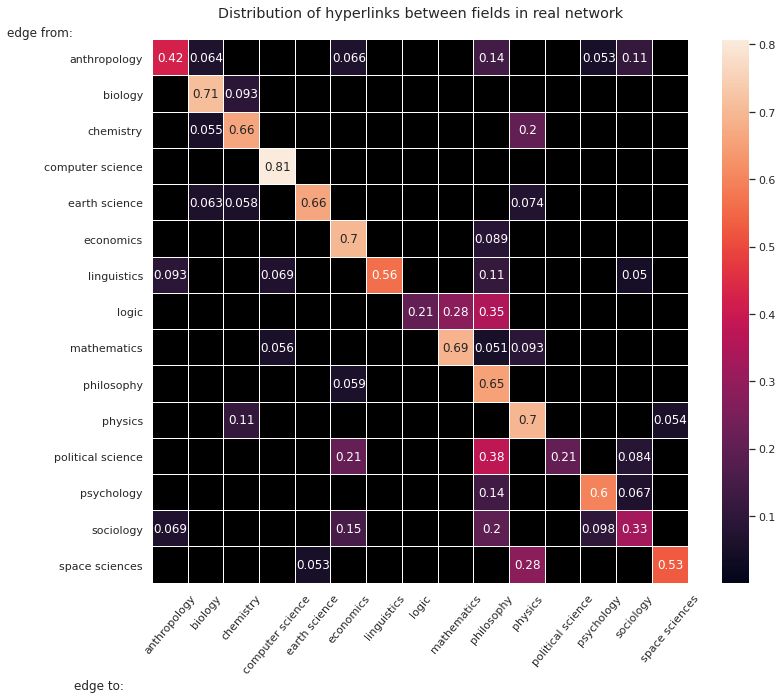

In [69]:
fig, ax = plt.subplots()
ax.set_facecolor("black")

sns.heatmap(
    field_link_matrix.div(field_link_matrix.sum(axis=1), axis=0),
    annot=field_link_matrix.div(field_link_matrix.sum(axis=1), axis=0).round(4),
    mask=field_link_matrix.div(field_link_matrix.sum(axis=1), axis=0) < 0.05,
    linewidths=0.01,
)
plt.xlabel("edge to:", position=(-0.1, 0))
plt.xticks(rotation=50)
plt.ylabel("edge from:", rotation=0, position=(0, 1))
plt.title(
    "Distribution of hyperlinks between fields in real network\n", fontsize="large"
)

### predicting field with network attributes <a id="pred">

[**back**](#contents)

In [70]:
field_dummies = (
    filtered.groupby("node")
    .apply(
        lambda df: pd.DataFrame(
            {f: int(f in set(df["field"].values)) for f in fields["field"]}, index=[0]
        )
    )
    .reset_index(level=1)
    .drop("level_1", axis=1)
)

In [71]:
field_dummies.to_csv("output_data/field_dummies.csv")

In [72]:
field_dummies.corr().unstack().sort_values().to_frame().reset_index().loc[
    lambda df: df["level_0"] > df["level_1"]
].pipe(lambda df: pd.concat([df.head(10), df.tail(10)]))

,level_0,level_1,0
1,philosophy,computer science,-0.181241
3,economics,computer science,-0.164478
4,physics,computer science,-0.144952
6,mathematics,computer science,-0.141611
8,philosophy,mathematics,-0.138688
10,mathematics,economics,-0.134629
12,philosophy,economics,-0.116357
15,physics,philosophy,-0.114418
16,mathematics,biology,-0.112448
19,physics,economics,-0.111880


Text(0.5, 1.0, 'Correlation matrix of field dummies')

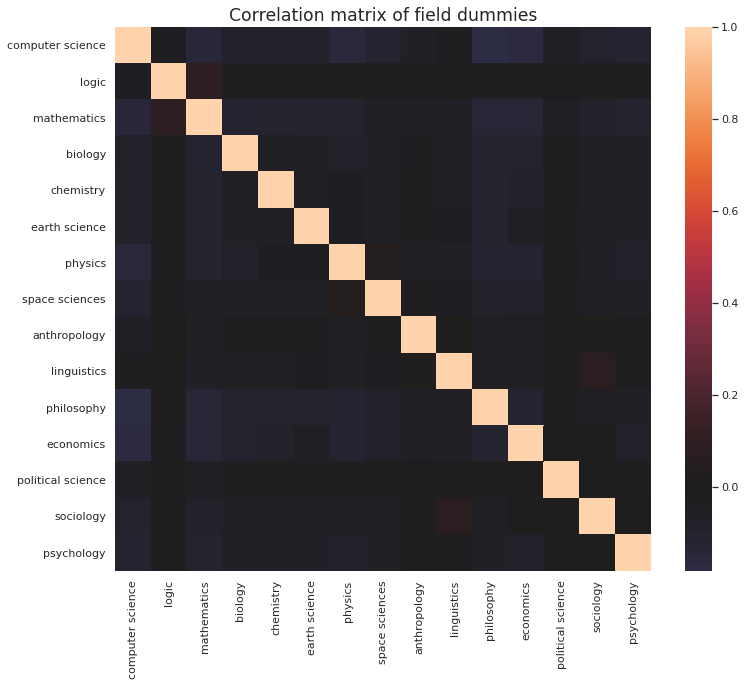

In [73]:
sns.heatmap(field_dummies.corr(), center=0)
plt.title("Correlation matrix of field dummies", fontsize="x-large")

In [74]:
reg_df = (
    filtered.drop_duplicates(["node", "field"])
    .groupby("node")
    .mean()
    .assign(
        p_within_field_in=lambda df: df["within_field_in_degree"] / df["in_degree"],
        p_within_field_out=lambda df: df["within_field_out_degree"] / df["out_degree"],
    )
    .fillna(0)
    .drop(["in_degree", "within_field_out_degree", "within_field_in_degree"], axis=1)
)

In [75]:
reg_df.to_csv("output_data/wiki_reg_df.csv")

In [76]:
X = pd.DataFrame(
    StandardScaler().fit_transform(reg_df), columns=reg_df.columns, index=reg_df.index,
).assign(const=1)

In [77]:
reg_metrics = {}

In [78]:
def logit_model(target_var):

    y = field_dummies[target_var]

    logit = Logit(y, X).fit()
    prediction = logit.predict(X)

    false_pos, true_pos, tresholds = metrics.roc_curve(y, prediction)
    auc = metrics.roc_auc_score(y, prediction)
    prec, rec, tresholds = metrics.precision_recall_curve(y, prediction)

    reg_metrics.update(
        {
            target_var: {
                "false_pos": false_pos,
                "true_pos": true_pos,
                "auc": auc,
                "prec": prec,
                "rec": rec,
            }
        }
    )
    
    return pd.DataFrame(
        [logit.params.rename("coeffs"), logit.pvalues.rename("p")]
    ).assign(field=target_var)

In [79]:
all_results = pd.concat(
    [logit_model(field) for field in fields["field"]]
)

Optimization terminated successfully.
         Current function value: 0.447970
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043837
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.402610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.193500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.097000
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.121987
 

In [80]:
field_coeff_matrix = (
    all_results.groupby("field")
    .apply(
        lambda df: df.loc["coeffs"]
        * (0.01 > df.loc["p"]).astype(int).replace(0, np.nan)
    )
    .drop("const", axis=1)
)

In [81]:
field_coeff_matrix.to_csv("output_data/wiki_field_coeff_matrix.csv")

In [82]:
with open("output_data/wiki_reg_metrics.p", "wb") as fp:
    pickle.dump(reg_metrics, fp)

Text(0.5, 1.0, 'Regression parameters by field and variable\n(real network)\n')

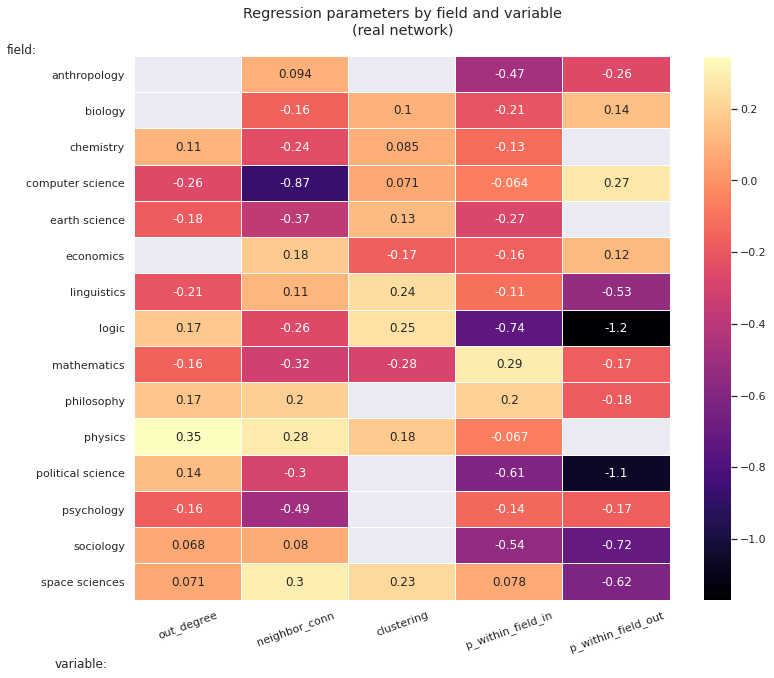

In [83]:
sns.heatmap(field_coeff_matrix, cmap="magma", annot=True, linewidth=0.01)
plt.xticks(rotation=20)
plt.ylabel("field:", rotation=0, position=(0, 1))
plt.xlabel("variable:", position=(-0.1, 0))
plt.title(
    "Regression parameters by field and variable\n(real network)\n", fontsize="large",
)

Text(0, 0.5, 'True positives')

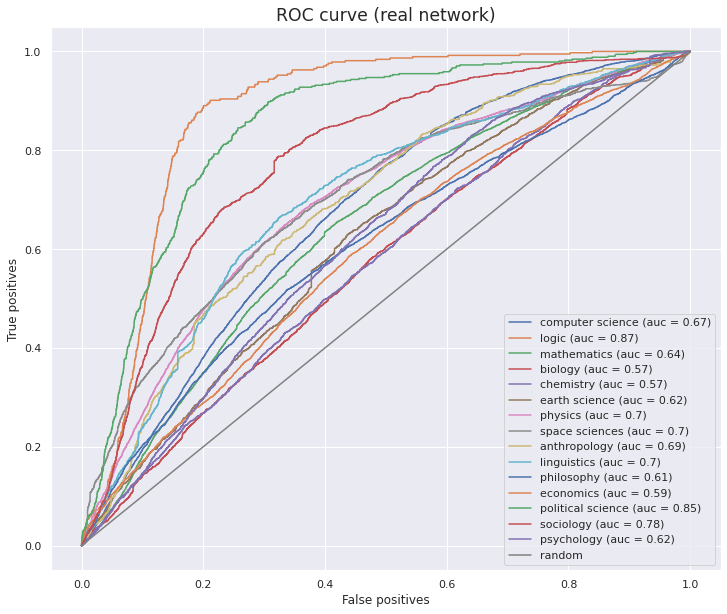

In [84]:
for f in reg_metrics.keys():

    plt.plot(
        reg_metrics[f]["false_pos"],
        reg_metrics[f]["true_pos"],
        label="{} (auc = {})".format(f, reg_metrics[f]["auc"].round(2)),
    )

plt.plot(np.linspace(0, 1), np.linspace(0, 1), c="grey", label="random")
plt.legend(loc=4)
plt.title("ROC curve (real network)", fontsize="x-large")
plt.xlabel("False positives")
plt.ylabel("True positives")

Text(0, 0.5, 'Recall')

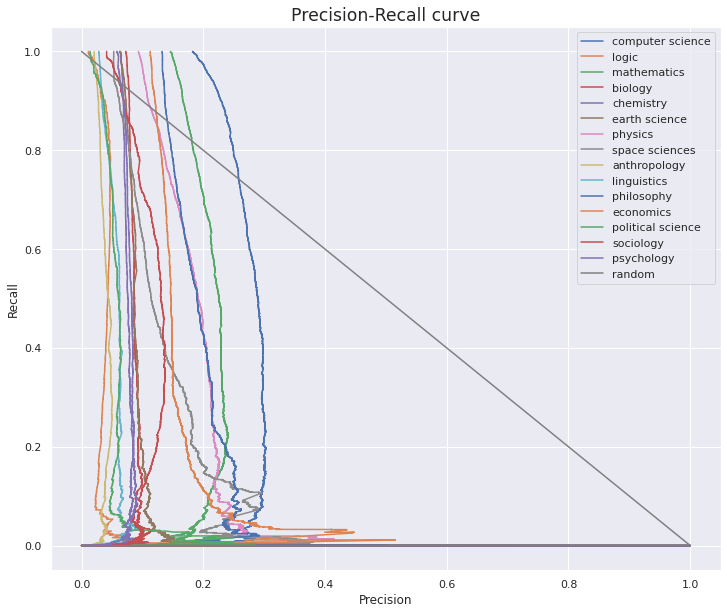

In [85]:
for f in reg_metrics.keys():

    plt.plot(
        reg_metrics[f]["prec"], reg_metrics[f]["rec"], label=f,
    )

plt.plot(np.linspace(0, 1), 1 - np.linspace(0, 1), c="grey", label="random")

plt.legend(loc=1)
plt.title("Precision-Recall curve", fontsize="x-large")
plt.xlabel("Precision")
plt.ylabel("Recall")

--------

### pyvis visualization <a id="pyvis"></a>

[**back**](#contents)

In [182]:
G_cat_pyvis = net.Network(
    notebook=True, height="750px", width="100%", bgcolor="#ffffff",
)

In [183]:
for idx, r in categories.iterrows():
    if r["category"] not in G_cat_pyvis.nodes:
        G_cat_pyvis.add_node(
            r["category"],
            mass=r["degree"] * 100,
            size=r["degree"] * 100,
            color=r["color"],
        )

In [184]:
for edge in cat_edges:
    G_cat_pyvis.add_edge(edge[0], edge[1], weight=edge[2] * 100, value=edge[2] * 100)

In [ ]:
G_cat_pyvis.show("output_data/G_cat_pyvis.html")

--------------

### circular visualization <a id="circular"></a>

[**back**](#contents)

$(x-u)^2+(y-v)^2=r^2$

$y= ^+_- \sqrt{r^2-(x-u)^2} + v$

In [859]:
def circle(r, n, center=(0, 0)):

    x_values = (
        np.linspace(-r, r, n // 2 + 1)
        if (n % 2 == 0)
        else np.linspace(-r, r, n // 2 + 2)
    )

    return (
        [[x + center[0], np.sqrt(r ** 2 - x ** 2) + center[1]] for x in x_values[:-1]]
        + [
            [x + center[0], -np.sqrt(r ** 2 - x ** 2) + center[1]]
            for x in x_values[::-1][:-1]
        ]
    )[:n]

In [860]:
fields["centers"] = circle(100, fields.shape[0])

*add number of categories...*

In [ ]:
fields["positions"] = fields.apply(
    lambda r: circle(r["n_categories"], r["n_categories"], center=r["centers"]), axis=1
)

In [91]:
cat_vis_df = pd.concat(
    [
        _fdf.drop_duplicates("category")
        .sort_values("degree")
        .assign(position=fields.loc[_fid, "positions"])
        .loc[:, ["category", "position", "degree", "field"]]
        for _fid, _fdf in categories.groupby("field")
    ]
).merge(colors, how="left", left_on="field", right_index=True)

In [34]:
cat_edges = (
    cat_edges.merge(
        categories[["category", "color"]],
        how="left",
        left_on="edge_1",
        right_on="category",
    )
    .drop("category", axis=1)
    .drop_duplicates(["edge_1", "edge_2"])
)

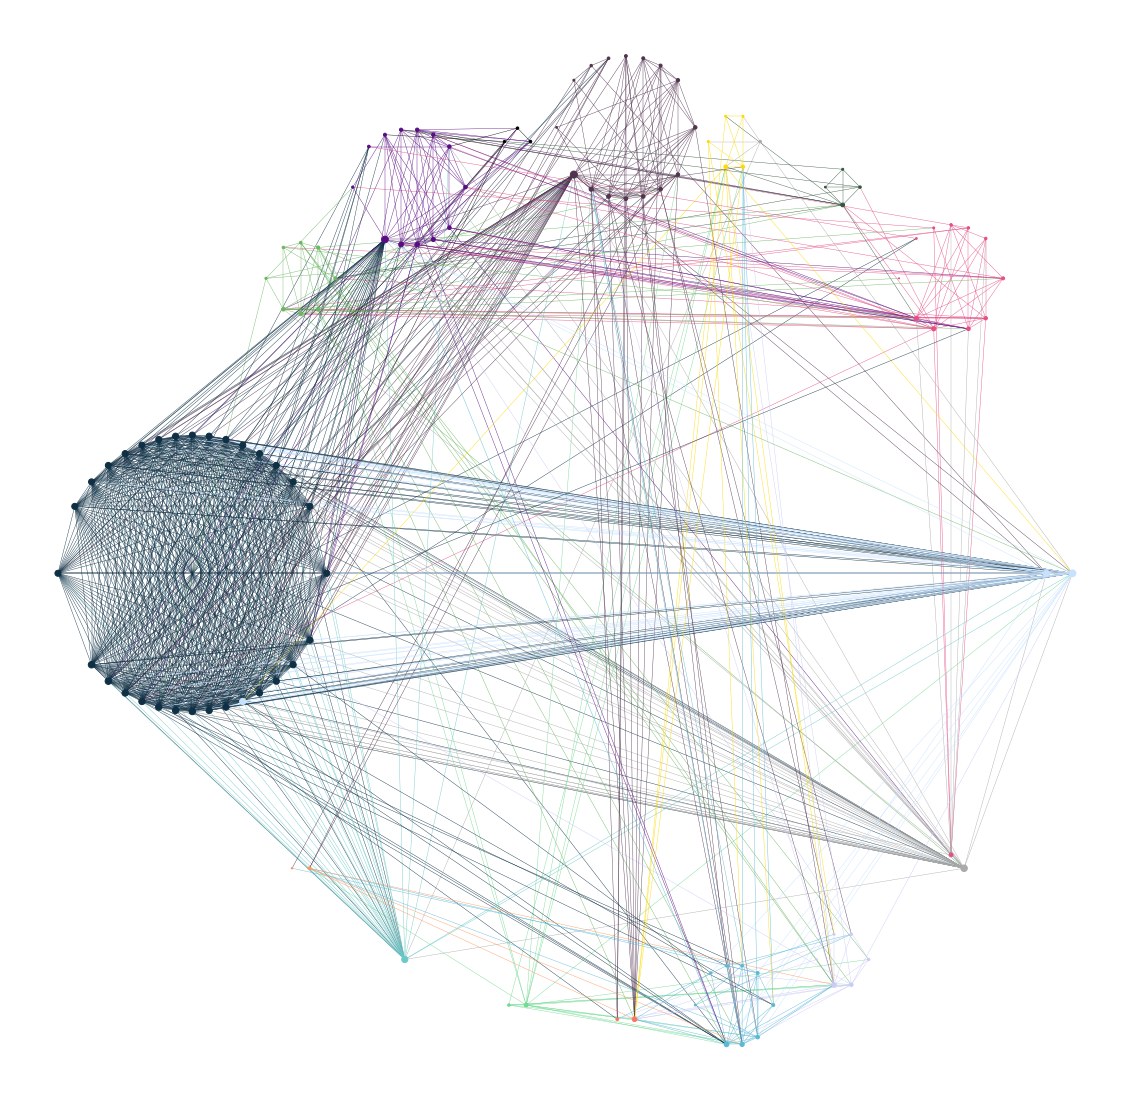

In [108]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.axis("off")
fig.set_facecolor("#FFFFFF")

nx.draw_networkx_nodes(
    G_cat,
    cat_vis_df.set_index("category")["position"].to_dict(),
    ax=ax,
    nodelist=cat_vis_df["category"].unique(),
    node_size=cat_vis_df.drop_duplicates("category")["degree"].values,
    node_color=cat_vis_df.drop_duplicates("category")["color"].values,
)

nx.draw_networkx_edges(
    G_cat,
    cat_vis_df.set_index("category")["position"].to_dict(),
    edgelist=cat_edges[["edge_1", "edge_2"]].values.tolist(),
    edge_color=cat_edges["color"].values,
    arrows=False,
    alpha=1,
    width=0.4,
)

---------